In [1]:
import numpy
import pandas

import conntility

from scipy.spatial.distance import cdist
import tqdm

from matplotlib import pyplot as plt

## Part 1:
Measure the strengths of statistical interactions in connectivity based on individual morphologies that are not capture by a fourth-order simplifed model

In [2]:
fn_rat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Rat_623um_squared_struc_conmat_filtered_compressed.h5"
fn_human = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_struc_conmat_filtered_compressed.h5"

loaded = "rat"  # Set to human to analyze that instead
extent_xz = 900
nbins_xz = 31
extent_y = 700
nbins_y = 41

if loaded == "rat":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_rat)
    col_y = "depth"
    col_xz = ["ss_flat_x", "ss_flat_y"]
elif loaded == "human":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_human)
    col_y = "y"
    col_xz = ["x", "z"]

dbins_xz = numpy.hstack([[0, 1E-12], numpy.linspace(1E-12, extent_xz, nbins_xz)])
binid_xz = numpy.arange(0, nbins_xz + 1)

dbins_y = numpy.linspace(-extent_y, extent_y, nbins_y)
binid_y = numpy.arange(0, nbins_y + 1)

M_h.vertices["mtype"].value_counts()

mtype
L3_TPC:A     8702
L2_TPC:B     7062
L3_TPC:C     2499
L2_TPC:A     1067
L2_IPC        707
L5_DBC          0
L5_LBC          0
L5_MC           0
L5_NBC          0
L5_NGC          0
L5_SBC          0
L5_TPC:A        0
L5_TPC:B        0
L5_TPC:C        0
L5_UPC          0
L6_BP           0
L1_DAC          0
L5_BTC          0
L6_BPC          0
L6_BTC          0
L6_CHC          0
L6_DBC          0
L6_HPC          0
L6_IPC          0
L6_LBC          0
L6_MC           0
L6_NBC          0
L6_NGC          0
L6_SBC          0
L6_TPC:A        0
L6_TPC:C        0
L5_CHC          0
L4_TPC          0
L5_BP           0
L23_NGC         0
L1_LAC          0
L1_NGC-DA       0
L1_NGC-SA       0
L1_SAC          0
L23_BP          0
L23_BTC         0
L23_CHC         0
L23_DBC         0
L23_LBC         0
L23_MC          0
L23_NBC         0
L23_SBC         0
L4_UPC          0
L4_BP           0
L4_BTC          0
L4_CHC          0
L4_DBC          0
L4_LBC          0
L4_MC           0
L4_NBC          0
L4_N

In [ ]:
from scipy.spatial import KDTree

_coords = col_xz + [col_y]
tree = KDTree(M_h.vertices[_coords].values)

_, nn_id = tree.query(M_h.vertices[_coords], k=2)
nn_id = nn_id[:, 1]  # nn_id[:, 0] is the original node, which has distance 0. nn_id[:, 1] is neighbor

# Lookup from pre / post ids to edge ids
edge_id_lookup = M_h._edge_indices.reset_index(drop=True).reset_index().set_index(["row", "col"])["index"]

In [ ]:
def for_pre_chunk(chunk_pre):
    # Which offset bin the pairs fall into
    Dxz = cdist(M_h.vertices.iloc[chunk_pre][col_xz], M_h.vertices[col_xz]) # PRE X POST
    Dxz = numpy.digitize(Dxz, dbins_xz) - 2  # -2 means distance = 0 will be bin id -1

    Dy = M_h.vertices.iloc[chunk_pre][[col_y]].values - M_h.vertices[[col_y]].values.transpose() # PRE X POST
    Dy = numpy.digitize(Dy, dbins_y) - 1  # NOTE: Negative values -> upwards connection
    
    # Numer of touches between them
    j, i = numpy.meshgrid(numpy.arange(len(M_h)), chunk_pre)
    assert j.shape == Dy.shape
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": i.flatten(), "col": j.flatten()}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count[v] = M_h.edges["count"].values[edge_ids[v]]
    
    # Number of touches with nearest neighbor (pre)
    _pre = nn_id[i.flatten()]; _post = j.flatten()
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": _pre, "col": _post}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count_nnpre = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count_nnpre[v] = M_h.edges["count"].values[edge_ids[v]]
    collision_pre = _pre != _post
    
    # Number of touches with nearest neighbor (post)
    _pre = i.flatten(); _post = nn_id[j.flatten()]
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": _pre, "col": _post}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count_nnpost = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count_nnpost[v] = M_h.edges["count"].values[edge_ids[v]]
    collision_post = _pre != _post
    
    # Count instances of each
    ret_pre = pandas.DataFrame({
        "xz": Dxz.flatten()[collision_pre],
        "y": Dy.flatten()[collision_pre],
        "touches_pair": touch_count[collision_pre],
        "touches_nn_pre": touch_count_nnpre[collision_pre],
    }).value_counts()
    
    ret_post = pandas.DataFrame({
        "xz": Dxz.flatten()[collision_post],
        "y": Dy.flatten()[collision_post],
        "touches_pair": touch_count[collision_post],
        "touches_nn_post": touch_count_nnpost[collision_post],
    }).value_counts()
    return ret_pre, ret_post
    


In [ ]:
#In each offset-bin: How many pairs exist?
full_master_pre = []
full_master_post = []
chunk_sz = 1000
chunking = numpy.arange(0, len(M_h) + chunk_sz, chunk_sz)

chunk_pre = numpy.arange(chunking[0], numpy.minimum(chunking[1], len(M_h)))
full_master_pre, full_master_post = for_pre_chunk(chunk_pre)

for a, b in tqdm.tqdm(list(zip(chunking[1:-1], chunking[2:]))):
    chunk_pre = numpy.arange(a, numpy.minimum(b, len(M_h)))
    new_master_pre, new_master_post = for_pre_chunk(chunk_pre)
    full_master_pre = full_master_pre.add(new_master_pre, fill_value=0)
    full_master_post = full_master_post.add(new_master_post, fill_value=0)


In [ ]:
full_master_pre = full_master_pre.reset_index()
full_master_post = full_master_post.reset_index()

bin_centers_y = numpy.hstack([
    0.5 * (dbins_y[:-1] + dbins_y[1:]),
    dbins_y[-1] + 0.5 * numpy.mean(numpy.diff(dbins_y))
])
bin_centers_xz = numpy.hstack([
    0.5 * (dbins_xz[1:-1] + dbins_xz[2:]),
    dbins_xz[-1] + 0.5 * numpy.mean(numpy.diff(dbins_xz[1:]))
])

In [ ]:
_v = full_master_pre["xz"] >= 0
full_master_pre["xz"][_v] = bin_centers_xz[full_master_pre["xz"][_v]]
full_master_pre["y"] = bin_centers_y[full_master_pre["y"]]

_v = full_master_post["xz"] >= 0
full_master_post["xz"][_v] = bin_centers_xz[full_master_post["xz"][_v]]
full_master_post["y"] = bin_centers_y[full_master_post["y"]]

In [ ]:
out_fn = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_effect.h5"

full_master_pre.to_hdf(out_fn, key="{0}/pre".format(loaded))
full_master_post.to_hdf(out_fn, key="{0}/post".format(loaded))

## Part 2:
Build a stochastic model of the process:
For a fourth order model, in each offset bin the number of neurons connected to a presynaptic partner would follow a binomial distribution. We show that the actual distribution based on touches in wider than that. Then we fit a gamma distribution to it. The stochastic model then uses random variates from the gamma distributions to determine how many connected neurons to pick. 

In [11]:
extent_xz = 900
nbins_xz = 16
extent_y = 700
nbins_y = 21

dbins_xz = numpy.hstack([[0, 1E-12], numpy.linspace(1E-12, extent_xz, nbins_xz)])
binid_xz = numpy.arange(0, nbins_xz + 1)

dbins_y = numpy.linspace(-extent_y, extent_y, nbins_y)
binid_y = numpy.arange(0, nbins_y + 1)

edge_id_lookup = M_h._edge_indices.reset_index(drop=True).reset_index().set_index(["row", "col"])["index"]

def for_pre_chunk(chunk_pre):
    # Which offset bin the pairs fall into
    Dxz = cdist(M_h.vertices.iloc[chunk_pre][col_xz], M_h.vertices[col_xz]) # PRE X POST
    Dxz = numpy.digitize(Dxz, dbins_xz) - 2  # -2 means distance = 0 will be bin id -1

    Dy = M_h.vertices.iloc[chunk_pre][[col_y]].values - M_h.vertices[[col_y]].values.transpose() # PRE X POST
    Dy = numpy.digitize(Dy, dbins_y) - 1  # NOTE: Negative values -> upwards connection
    
    # Numer of touches between them
    j, i = numpy.meshgrid(numpy.arange(len(M_h)), chunk_pre)
    assert j.shape == Dy.shape
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": i.flatten(), "col": j.flatten()}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count[v] = M_h.edges["count"].values[edge_ids[v]]
    touch_count.reshape(Dy.shape)
        
    # Count instances of each
    ret = pandas.DataFrame({
        "xz": Dxz.flatten(),
        "y": Dy.flatten(),
        "touches_pair": touch_count,
        "pre id": i.flatten(),
    }).value_counts()
    
    return ret
    


In [12]:
tst = []
chunk_sz = 1000
chunking = numpy.arange(0, len(M_h) + chunk_sz, chunk_sz)

for a, b in tqdm.tqdm(list(zip(chunking[:-1], chunking[1:]))):
    chunk_pre = numpy.arange(a, numpy.minimum(b, len(M_h)))
    tst.append(for_pre_chunk(chunk_pre))
    
tst = pandas.concat(tst, axis=0)

100%|██████████| 21/21 [02:43<00:00,  7.76s/it]


In [13]:
# We introduce a threshold for minimum number of touches to make the results sparser. That enables simplex counting later
thresh = 7  # HOW MANY TOUCHES NEED TO BE REACHED FOR A CONNECTION


def m_p_mdl(df_in):
    M = df_in.pivot(index="touches_pair", columns="pre id", values="count")
    V = pandas.concat([M.sum(axis=0), M.loc[thresh:].sum(axis=0) / M.sum(axis=0)], axis=1, keys=["N", "P"])
    return V

foo = tst.reset_index().groupby(["xz", "y"]).apply(m_p_mdl)

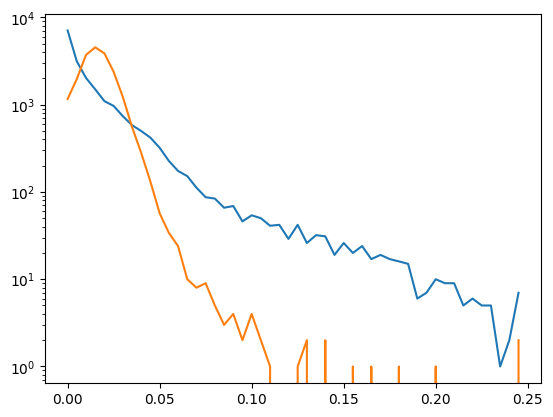

In [14]:
from scipy import stats 

p_bins = numpy.linspace(0, 0.25, 51)
meh = foo.loc[(3, 10)] # Results from an exemplary offset bin

H = numpy.histogram(meh["P"], bins=p_bins)[0] # Distribution in the data
plt.plot(p_bins[:-1], H)

p = (meh["N"] * meh["P"]).sum() / meh["N"].sum()
Pctrl = stats.binom(meh["N"].astype(int), p).rvs() / meh["N"]  # Expected in a fourth-order model: Binomial
H = numpy.histogram(Pctrl, bins=p_bins)[0]
plt.plot(p_bins[:-1], H)
plt.gca().set_yscale("log")

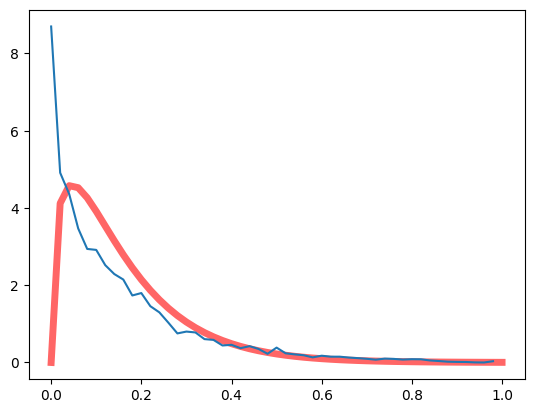

In [15]:
from scipy.stats import gamma

p_bins = numpy.linspace(0, 1, 51)

meh = foo.loc[(1, 10)]
fitres = stats.fit(stats.gamma, meh["P"], bounds={"a":[1E-6, 25], "scale": [0.01, 1.0]})
a = fitres.params[0]
scale = fitres.params[2]

H = numpy.histogram(meh["P"], bins=p_bins, density=True)[0]

#a = 1.81
plt.plot(p_bins, gamma(a, scale=scale).pdf(p_bins),
       'r-', lw=5, alpha=0.6, label='gamma pdf')
plt.plot(p_bins[:-1], H)

In [16]:
def perform_fit(df_in):
    fitres = stats.fit(stats.gamma, df_in["P"], bounds={"a":[1E-6, 25], "scale": [0.01, 1.0]})
    a = fitres.params[0]
    scale = fitres.params[2]
    return pandas.Series({"a": a, "scale": scale})

res = foo.groupby(["xz", "y"]).apply(perform_fit)

In [ ]:
out_fn = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_gamma_model.h5"

res.to_hdf(out_fn, key="{0}".format(loaded))

## Run the model

In [17]:
def mdl_pre_chunk(chunk_pre):
    Dxz = cdist(M_h.vertices.iloc[chunk_pre][col_xz], M_h.vertices[col_xz]) # PRE X POST
    Dxz = numpy.digitize(Dxz, dbins_xz) - 2  # -2 means distance = 0 will be bin id -1

    Dy = M_h.vertices.iloc[chunk_pre][[col_y]].values - M_h.vertices[[col_y]].values.transpose() # PRE X POST
    Dy = numpy.digitize(Dy, dbins_y) - 1  # NOTE: Negative values -> upwards connection

    # USE MESHGRID, NERD!
    pre_id = numpy.repeat(chunk_pre.reshape((-1, 1)), Dy.shape[1], axis=1)
    post_id = numpy.repeat(numpy.arange(Dy.shape[1]).reshape((1, -1)), len(chunk_pre), axis=0)
    
    lo = pandas.DataFrame({
        "xz": Dxz.flatten(),
        "y": Dy.flatten(),
        "pre": pre_id.flatten()
    })
    lo_idx = pandas.MultiIndex.from_frame(lo)
    
    evaluated = res.apply(lambda _x: pandas.Series(gamma(_x["a"], scale=_x["scale"]).rvs(size=len(chunk_pre)),
                                               index=pandas.Index(chunk_pre, name="pre")), axis=1).stack()
    P = evaluated[lo_idx].values.reshape(Dy.shape)
    M = numpy.random.rand(*P.shape) <= P

    return pandas.DataFrame({"row": pre_id[M], "col": post_id[M]})

In [18]:
#In each offset-bin: How many pairs exist?
mdl_edge_table = []
chunk_sz = 2500
chunking = numpy.arange(0, len(M_h) + chunk_sz, chunk_sz)

for a, b in tqdm.tqdm(list(zip(chunking[:-1], chunking[1:]))):
    chunk_pre = numpy.arange(a, numpy.minimum(b, len(M_h)))
    mdl_edge_table.append(mdl_pre_chunk(chunk_pre))
mdl_edge_table = pandas.concat(mdl_edge_table, axis=0)

100%|██████████| 9/9 [05:53<00:00, 39.27s/it]


In [19]:
from scipy import sparse

edge_props = pandas.DataFrame({"connected": numpy.ones(len(mdl_edge_table), dtype=bool)})

myM = conntility.ConnectivityMatrix(mdl_edge_table, vertex_properties=M_h._vertex_properties,
                                    edge_properties=edge_props,
                                    shape=(len(M_h), len(M_h)))

In [3]:
# myM.to_h5("/gpfs/bbp.cscs.ch/project/proj159/home/reimann/rat_gamma_corr_model.h5")
myM = conntility.ConnectivityMatrix.from_h5("/gpfs/bbp.cscs.ch/project/proj159/home/reimann/rat_gamma_corr_model.h5")

In [20]:
width = 200
center = myM.vertices[["ss_flat_x", "ss_flat_y"]].mean()

spM = myM
dataM = M_h.filter("count").ge(5)
for _coord in ["ss_flat_x", "ss_flat_y"]:
    spM = spM.index(_coord).lt(center[_coord] + width).index(_coord).gt(center[_coord] - width)
    dataM = dataM.index(_coord).lt(center[_coord] + width).index(_coord).gt(center[_coord] - width)

 2024-07-08 19:53:41,159: No seed among keyword arguments
 2024-07-08 19:53:41,331: Shuffle 934951 edges following Erdos-Renyi


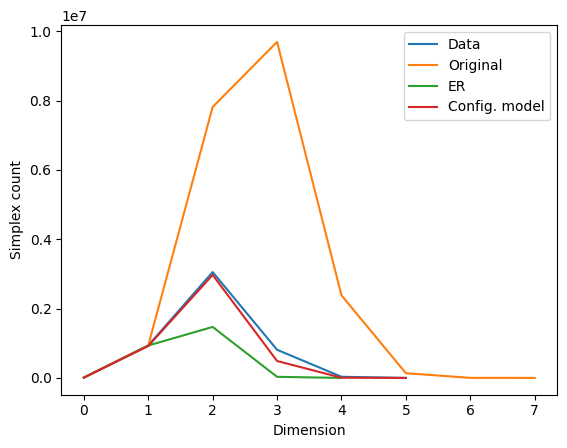

In [26]:
import connalysis
from scipy import sparse

_m = spM.array
_n = dataM.array > 0
numpy.fill_diagonal(_m, False) # Currently the stochastic model builds autapses. Can be easily fixed later.
p = 0.5
__m = (_m * (numpy.random.rand(*_m.shape) < p)).astype(int)
__n = (_n * (numpy.random.rand(*_n.shape) < (__m.mean() / _n.mean()))).astype(int)

plt.plot(connalysis.network.topology.simplex_counts(__m), label="Data")
plt.plot(connalysis.network.topology.simplex_counts(__n), label="Original")
_c = connalysis.randomization.ER_shuffle(sparse.coo_matrix(__n))
plt.plot(connalysis.network.topology.simplex_counts(_c), label="ER")
_c = connalysis.randomization.configuration_model(sparse.coo_matrix(__n))
plt.plot(connalysis.network.topology.simplex_counts(_c), label="Config. model")

plt.gca().set_xlabel("Dimension")
plt.gca().set_ylabel("Simplex count")
plt.legend()